<a href="https://colab.research.google.com/github/isabellebouchard/ift6135/blob/master/Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO
- check that mnist data isn't in order from 1-9
- I did train 80%, validate 20% (check MLP)
- going to have to change the activation function in MLP from sigmoid (11% accuracy aka random) to ReLU (95% accuracy)
- try using Leaky ReLU as activation function 
- can we use dropout?
- add dilation?
- check if its better to have smaller filters at the beginning or end of network (see textbook)
- can we add batchnorm? 
- add more parameters to match MLP
- separate train from evaluate (commented out right now)
- can we change batch size? batch size 34 gives 98%


# Problem 2

**Instructions**: For this part of the assignment we will train a convolutional network on MNIST
for 10 epochs using your favorite deep learning frameworks such as Pytorch of Tensor
ow. Plot the
train and valid errors at the end of each epoch for the model.
1. Come up with a CNN architecture with more or less similar number of parameters as MLP
trained in Problem 1 and describe it.

MLP in Problem 1:

*   two hidden layers
*   input data size is 784 and output is parameterized by a softmax of 10 classes
*   train using probability loss (cross entropy) and minimize this criterion to optimize the model parameters using SGD
*   non-linearity chosen as neuron activation (activation function): sigmoid (we should try ReLu)
*   learning rate: 1.e-2
*   mini-batch size: 128


2. Compare the performances of CNN vs MLP. Comment.

You could take reference from the architecture mentioned here: 
https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch 




# CNN Architecture



**Input Image**: 28 x 28

**Convolution 1**: 32 filters, kernel size = 5, stide = 1,  padding = 2

**Max pooling 1**: kernel size = 2

**Convolution 2**: 64 filters, kernel size = 5, stide = 1,  padding = 2

**Max pooling 2**: kernel size = 2

**Convolution 3**: 128 filters, kernel size = 5, stide = 1,  padding = 2

**Max pooling 3**: kernel size = 2

**Convolution 4**: 256 filters, kernel size = 3, stide = 1,  padding = 2

**Max pooling 4**: kernel size = 2

**Fully Connected Layer**: 2 x 2 x 256 

**Ouput:** 10 x 1

**Loss:** softmax + cross-entropy



### Installation Requirements

In [1]:
!pip3 install torch torchvision matplotlib 

    100% |████████████████████████████████| 2.0MB 10.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


### Use GPU 

First, select "GPU" in the Edit Menu -> Notebook Settings -> Hardware Accelerator -> GPU

**torch.cuda**: *This package adds support for CUDA tensor types, that implement the same function as CPU tensors, but they utilize GPUs for computation.*

**torch.cuda.is_available()**: *Returns a bool indicating if CUDA is currently available.*

To go from a tensor type CPU to GPU, add .to("cuda:0")

In [2]:
import torch

use_gpu = torch.cuda.is_available()
print("GPU Available: {}".format(use_gpu))
device = torch.device("cuda:0" if use_gpu else "cpu")

GPU Available: True


### MNIST Data

Get MNIST Data, split in train/validate/test and load in DataLoader

In [3]:
from torch.utils.data import sampler, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np
import random

batch_size = 34

# ChunkSampler class is from https://github.com/pytorch/vision/issues/168
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

train_set = MNIST(root='../data',train=True,transform=transforms.ToTensor(),download=True)
test_set = MNIST(root='../data',train=False,transform=transforms.ToTensor(),download=True)

train_set_size = len(train_set)
NUM_TRAIN = int(0.8 * train_set_size) #cast to int to avoid TypeError: 'float' object cannot be interpreted as an integer
NUM_VAL = train_set_size - NUM_TRAIN
NUM_TEST = len(test_set)

loader_train = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0),shuffle=False)
loader_val = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN),shuffle=False)
loader_test = DataLoader(test_set, batch_size=batch_size,shuffle=False)

Processing...
Done!


### CNN Model

[torch.nn.Module](https://pytorch.org/docs/master/nn.html#torch.nn.Module): Base class for all NN modules. 
Must implement __init__ (defines the layers) and **forward** (returns the output)

[torch.nn.Sequential(*args)](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential): Modules will be added to it in the order they are passed in the constructor

 [torch.nn.Conv2d](https://pytorch.org/docs/master/nn.html#torch.nn.Conv2d)(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
 
[ torch.nn.Sigmoid](https://pytorch.org/docs/master/nn.html#sigmoid)

[torch.nn.MaxPool2d](https://pytorch.org/docs/master/nn.html#torch.nn.MaxPool2d)(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False): Applies a 2D max pooling over an input signal composed of several input planes.

 [torch.nn.Dropout2d](https://pytorch.org/docs/master/nn.html#dropout2d)(p=0.5, inplace=False): *Each channel will be zeroed out independently on every forward call. with probability p using samples from a Bernoulli distribution*

 [torch.nn.Linear](https://pytorch.org/docs/master/nn.html#torch.nn.Linear)(in_features, out_features, bias=True)


In [4]:
import torch.nn as nn
import copy

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=5,padding=2),
        #nn.Sigmoid(),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.conv2 = nn.Sequential(
        nn.Conv2d(32,64,kernel_size=5,padding=2),
        #nn.Sigmoid(),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())

    self.conv3 = nn.Sequential(
        nn.Conv2d(64,128,kernel_size=5,padding=2),
        #nn.Sigmoid(),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.conv4 = nn.Sequential(
        nn.Conv2d(128,256,kernel_size=3,padding=2),
        #nn.Sigmoid(),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.fc = nn.Linear(2*2*256,10)

  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    flatten = out.view(out.size(0),-1)
    fc = self.fc(flatten)
    return fc

model = CNN()
# put model on GPU
model = model.to(device)

print(model)

print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

# Save the initial weights of model
init_model_wts = copy.deepcopy(model.state_dict())

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (fc): Linear(in_features=1024, out_features=10, bias=True)
)


# Parameters:  5

### Train CNN

#### Loss function

criterion = [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss)(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

#### Minimize loss function using stochastic gradient descent
optimizer = [torch.optim.SGD](https://pytorch.org/docs/master/optim.html#torch.optim.SGD)(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)


In [6]:
learning_rate = 1e-2
num_epochs = 10

#loss function
criterion = nn.CrossEntropyLoss()  

#optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model.load_state_dict(init_model_wts)

train_errors = []
eval_errors = []

print("Training begins...")
for epoch in range(num_epochs):
  
  train_error = 0
  train_num = 0
  
  # model in train mode
  model.train()
  
  for digits, labels in loader_train:
    
    # digits and labels on GPU
    digits = digits.to(device)
    labels = labels.to(device)
    
    # zero gradient buffer
    optimizer.zero_grad()
    
    # forward pass
    outputs = model(digits)
        
    # loss function
    loss = criterion(outputs,labels)
        
    # backward pass
    loss.backward()
    
    # gradient descent step
    optimizer.step()
    
    # add the loss
    train_error += loss.item()
    train_num += 1
  
  eval_error = 0
  eval_num = 0
  
  # model in eval mode
  model.eval()
  
  for digits, labels in loader_val:
    
    # digits and labels on GPU
    digits = digits.to(device)
    labels = labels.to(device)
        
    # forward pass
    outputs = model(digits)
    
    # loss function
    loss = criterion(outputs,labels)
        
    # add the loss
    eval_error += loss.item()
    eval_num += 1
  
  # save the loss
  train_errors.append(train_error / train_num)
  eval_errors.append(eval_error / eval_num)
  
  #print eval_error after each epoch
  print('\nEpoch {}'.format(epoch + 1))
  print('\tTrain error: {:.4f}'.format(train_error/train_num))  
  print('\tEval error: {:.4f}'.format(eval_error/eval_num))
  

Training begins...

Epoch 1
	Train error: 2.2827
	Eval error: 2.1012

Epoch 2
	Train error: 0.9020
	Eval error: 0.2557

Epoch 3
	Train error: 0.3235
	Eval error: 0.1429

Epoch 4
	Train error: 0.2251
	Eval error: 0.1132

Epoch 5
	Train error: 0.1863
	Eval error: 0.0902

Epoch 6
	Train error: 0.1579
	Eval error: 0.0788

Epoch 7
	Train error: 0.1411
	Eval error: 0.0689

Epoch 8
	Train error: 0.1268
	Eval error: 0.0662

Epoch 9
	Train error: 0.1160
	Eval error: 0.0626

Epoch 10
	Train error: 0.1062
	Eval error: 0.0545


### Evaluate CNN


In [0]:
# eval_errors = []

# print("Evaluation begins...")

# for epoch in range(num_epochs):
  
#   eval_error = 0
#   eval_num = 0
  
#   # model in eval mode
#   model.eval()
  
#   for digits, labels in loader_val:
    
#     # digits and labels on GPU
#     digits = digits.to(device)
#     labels = labels.to(device)
        
#     # forward pass
#     outputs = model(digits)
    
#     # loss function
#     loss = criterion(outputs,labels)
        
#     # add the loss
#     eval_error += loss.item()
#     eval_num += 1
  
#   # save the loss
#   eval_errors.append(eval_error / eval_num)
  
#   #print eval_error after each epoch
#   print('\nEpoch {}'.format(epoch + 1))
#   print('\tEval error: {:.4f}'.format(eval_error/eval_num))
    

### Plot Train and Valid Errors

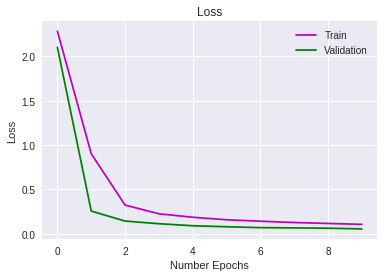

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training and validation curve
x = list(range(len(train_errors))) 
plt.plot(x, train_errors,'m',label='Train')
plt.plot(x, eval_errors,'g', label='Validation')

plt.xlabel('Number Epochs')
plt.ylabel('Loss')
plt.legend(loc='best',shadow=True, fancybox=True)
plt.title("Loss")

plt.show()

### Test CNN

In [14]:
# model in eval mode
model.eval()

correct = 0
total = 0

for digits, labels in loader_test:
  
  # digits and labels on GPU
  digits = digits.to(device)
  labels = labels.to(device)
  
  # forward pass
  outputs = model(digits)
  _, predicted = torch.max(outputs.data, 1)
  
  # save the accuary
  
  total += labels.size(0)
  correct += torch.sum(predicted == labels.data)
  
print('Accuracy on the test set: {:.2f}%'.format(100 * correct / total))
  

Accuracy on the test set: 98.00%


# CNN vs. MLP 

## Number of parameters

**CNN with 4 conv layers**

conv1 = 32 filters size 5x5 + 32 biases = 32x5x5+32 = 832

conv2 = 32x64 filters size 5x5 + 64 biases = 32x64x5x5 + 64 = 51,264

conv3 = 64x128 filters size 5x5 + 128 biases = 64x128x5x5 + 128 = 204,928

conv4 = 128x256 filters size 3x3 + 256 biases = 128x256x3x3 + 256 = 295,168

fc = 1x(2x2x256) x 10 + 10 = 10,250

total CNN parameters = 832 + 51,264 + 204,928 + 295,168 + 10,250 = **562,442**



**MLP with 2 hidden layers**

input to h1 = 784 x 512 = 401,408

h1 to h2 = 512 x 1024 = 524,288

h2 to output = 1024 x 10 = 10,240

total MLP parameters = 401,408 + 524,288 + 10,240 = **935,936**

## Discussion

CNN's need significantly less parameters than MLP since they exhibit sparse connectivity and parameter sharing. 

**Sparse connectivity**: direct connections very sparse, but in the deeper layers, units are indirectly connected to all/most of the input image. 

**Parameter sharing**: each member of the kernel is used at every position of the input, meaning the same parameters are used at all input locations. Therefore you learn only one set of parameters. 

Since we are asked to build a CNN with similar number of parameters as the MLP trained in Problem 1, the CNN should outperform the MLP since it needs a significantly smaller number of weights to be able to match an MLP's performance. 

## Performance

If m represents the size of the input image, and n the size of the output image, then MLP requires mxn parameters with O(mxn) runtime. In CNNs, you limit the number of connections of each output to k, this means you only need kxn parameters with O(kxn) runtime. 


# References

List of references we can check out to increase our performance:

*   MNIST Image Class Tensorflow CNN 99.51% Test Accur.: https://www.kaggle.com/raoulma/mnist-image-class-tensorflow-cnn-99-51-test-acc
*   How to Choose CNN Architecture for MNIST: https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
*   99.75% Accur: https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist/notebook

